# Generative AI Use Case: Summarise Dialouge using FLAN-T5 LLM

Welcome to the practical side of this course. In this lab you will do the dialogue summarization task using generative AI. You will explore how the input text affects the output of the model, and perform prompt engineering to direct it towards the task you need. By comparing zero shot, one shot, and few shot inferences, you will take the first step towards prompt engineering and see how it can enhance the generative output of Large Language Models.

##### Citations and Credits
- This is the hands-on execise lab 1 assignment completed as part of "Generative AI with Large Language Models" couse on Coursera.com.

# Exercise Content

- [ 1 - Set up Kernel and Required Dependencies](#1)
- [ 2 - Summarize Dialogue without Prompt Engineering](#2)
- [ 3 - Summarize Dialogue with an Instruction Prompt](#3)
  - [ 3.1 - Zero Shot Inference with an Instruction Prompt](#3.1)
  - [ 3.2 - Zero Shot Inference with the Prompt Template from FLAN-T5](#3.2)
- [ 4 - Summarize Dialogue with One Shot and Few Shot Inference](#4)
  - [ 4.1 - One Shot Inference](#4.1)
  - [ 4.2 - Few Shot Inference](#4.2)
- [ 5 - Generative Configuration Parameters for Inference](#5)


<a name='1'></a>
## 1 - Set up Kernel and Required Dependencies

First, check that the correct kernel is chosen.
[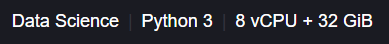](http://)

You can click on that (top right of the screen) to see and check the details of the image, kernel, and instance type.

[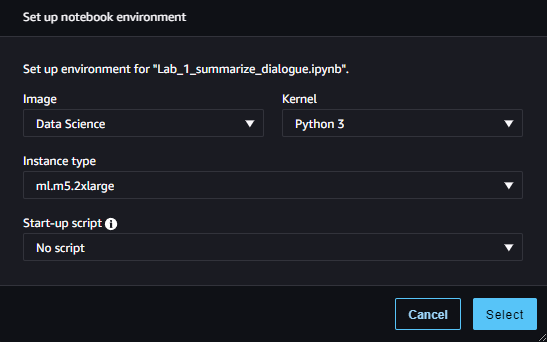!](http://)

Now install the required packages to use PyTorch and Hugging Face transformers and datasets.

In [1]:
%pip install --upgrade pip
%pip install --disable-pip-version-check \
    torch==1.13.1 \
    torchdata==0.5.1 --quiet

%pip install \
    transformers==4.27.2 \
    datasets==2.11.0  --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
Note: you may need to restart the kernel to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.1+cpu requires torch==2.0.0, but you have torch 1.13.1 which is incompatible.
torchtext 0.15.1+cpu requires torch==2.0.0, but you have torch 1.13.1 which is incompatible.
torchtext 0.15.1+cpu requires torchdata==0.6.0, but you have torchdata 0.5.1 which is incompatible.
torchvision 0.15.1+cpu requires torch==2.0.0, but you have torch 1.13.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Load the datasets, Large Language Model (LLM), tokenizer, and configurator. Do not worry if you do not understand yet all of those components - they will be described and discussed later in the notebook.

In [2]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM
from transformers import AutoTokenizer
from transformers import GenerationConfig

<a name='2'></a>
## 2 - Summarize Dialogue without Prompt Engineering

In this use case, you will be generating a summary of a dialogue with the pre-trained Large Language Model (LLM) FLAN-T5 from Hugging Face. The list of available models in the Hugging Face `transformers` package can be found [here](https://huggingface.co/docs/transformers/index). 

Let's upload some simple dialogues from the [DialogSum](https://huggingface.co/datasets/knkarthick/dialogsum) Hugging Face dataset. This dataset contains 10,000+ dialogues with the corresponding manually labeled summaries and topics. 

In [3]:
huggingface_dataset_name = "knkarthick/dialogsum"

dataset = load_dataset(huggingface_dataset_name)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/knkarthick___csv/knkarthick--dialogsum-cd36827d3490488d/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Print a couple of dialogues with their baseline summaries.

In [4]:
example_indices = [40, 200]

dash_line = '-'.join('' for x in range(100))

for i, index in enumerate(example_indices):
    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print('INPUT DIALOGUE:')
    print(dataset['test'][index]['dialogue'])
    print(dash_line)
    print('BASELINE HUMAN SUMMARY:')
    print(dataset['test'][index]['summary'])
    print(dash_line)
    print()

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT DIALOGUE:
#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.
---------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Exa

Load the [FLAN-T5 model](https://huggingface.co/docs/transformers/model_doc/flan-t5), creating an instance of the `AutoModelForSeq2SeqLM` class with the `.from_pretrained()` method. 

In [5]:
model_name='google/flan-t5-base'

model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

To perform encoding and decoding, you need to work with text in a tokenized form. **Tokenization** is the process of splitting texts into smaller units that can be processed by the LLM models. 

Download the tokenizer for the FLAN-T5 model using `AutoTokenizer.from_pretrained()` method. Parameter `use_fast` switches on fast tokenizer. At this stage, there is no need to go into the details of that, but you can find the tokenizer parameters in the [documentation](https://huggingface.co/docs/transformers/v4.28.1/en/model_doc/auto#transformers.AutoTokenizer).

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

Test the tokenizer encoding and decoding a simple sentence:

In [7]:
sentence = "What time is it, Tom?"

sentence_encoded = tokenizer(sentence, return_tensors='pt')

sentence_decoded = tokenizer.decode(
        sentence_encoded["input_ids"][0], 
        skip_special_tokens=True
    )

print('ENCODED SENTENCE:')
print(sentence_encoded["input_ids"][0])
print('\nDECODED SENTENCE:')
print(sentence_decoded)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

ENCODED SENTENCE:
tensor([ 363,   97,   19,   34,    6, 3059,   58,    1])

DECODED SENTENCE:
What time is it, Tom?


In [8]:
print(sentence_encoded)

{'input_ids': tensor([[ 363,   97,   19,   34,    6, 3059,   58,    1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}


Now it's time to explore how well the base LLM summarizes a dialogue without any prompt engineering. **Prompt engineering** is an act of a human changing the **prompt** (input) to improve the response for a given task.

In [9]:
for i, index in enumerate(example_indices):
    dialogue = dataset['test'][index]['dialogue']
    summary = dataset['test'][index]['summary']
    
    inputs = tokenizer(dialogue, return_tensors='pt')
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"], 
            max_new_tokens=50,
        )[0], 
        skip_special_tokens=True
    )
    
    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print(f'INPUT PROMPT:\n{dialogue}')
    print(dash_line)
    print(f'BASELINE HUMAN SUMMARY:\n{summary}')
    print(dash_line)
    print(f'MODEL GENERATION - WITHOUT PROMPT ENGINEERING:\n{output}\n')

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT PROMPT:
#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.
---------------------------------------------------------------------------------------------------
MODEL GENERATION - WITHOUT PROMPT ENGINEERING:
Person1: It's ten to nine.

-------------------------------

In [10]:
model.generate(
            inputs["input_ids"], 
            max_new_tokens=50,
        )

tensor([[    0,  1713,   345, 13515,   536,  4663,    10,    27,    31,    51,
          1631,    13, 21066,    82,  1218,     5,     1]])

You can see that the guesses of the model make some sense, but it doesn't seem to be sure what task it is supposed to accomplish. Seems it just makes up the next sentence in the dialogue. Prompt engineering can help here.

<a name='3'></a>
## 3 - Summarize Dialogue with an Instruction Prompt

Prompt engineering is an important concept in using foundation models for text generation. You can check out [this blog](https://www.amazon.science/blog/emnlp-prompt-engineering-is-the-new-feature-engineering) from Amazon Science for a quick introduction to prompt engineering.

<a name='3.1'></a>
### 3.1 - Zero Shot Inference with an Instruction Prompt

In order to instruct the model to perform a task - summarize a dialogue - you can take the dialogue and convert it into an instruction prompt. This is often called **zero shot inference**.  You can check out [this blog from AWS](https://aws.amazon.com/blogs/machine-learning/zero-shot-prompting-for-the-flan-t5-foundation-model-in-amazon-sagemaker-jumpstart/) for a quick description of what zero shot learning is and why it is an important concept to the LLM model.

Wrap the dialogue in a descriptive instruction and see how the generated text will change:

In [11]:
for i, index in enumerate(example_indices):
    dialogue = dataset['test'][index]['dialogue']
    summary = dataset['test'][index]['summary']

    prompt = f"""
Summarize the following conversation.

{dialogue}

Summary:
    """

    # Input constructed prompt instead of the dialogue.
    inputs = tokenizer(prompt, return_tensors='pt')
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"], 
            max_new_tokens=50,
        )[0], 
        skip_special_tokens=True
    )
    
    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print(f'INPUT PROMPT:\n{prompt}')
    print(dash_line)
    print(f'BASELINE HUMAN SUMMARY:\n{summary}')
    print(dash_line)    
    print(f'MODEL GENERATION - ZERO SHOT:\n{output}\n')

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Summarize the following conversation.

#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.

Summary:
    
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.
---------------------------------------------------------------------------------------------------
MODEL GENERATION - ZERO SHOT:
The train is about to

This is much better! But the model still does not pick up on the nuance of the conversations though.

**Exercise:**

- Experiment with the `prompt` text and see how the inferences will be changed. Will the inferences change if you end the prompt with just empty string vs. `Summary: `?
- Try to rephrase the beginning of the `prompt` text from `Summarize the following conversation.` to something different - and see how it will influence the generated output.

**Solving the above mentioned exercise - first point**
- Experiment with the `prompt` text and see how the inferences will be changed. Will the inferences change if you end the prompt with just empty string vs. `Summary: `

**Observations after soving execrcise for First Point**
- Inference for example 1 is changed

In [12]:
for i, index in enumerate(example_indices):
    dialogue = dataset['test'][index]['dialogue']
    summary = dataset['test'][index]['summary']
    
    # Prompt with just empty string
    prompt = f"""
Summarize the following conversation.

{dialogue}


    """

    # Input constructed prompt instead of the dialogue.
    inputs = tokenizer(prompt, return_tensors='pt')
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"], 
            max_new_tokens=50,
        )[0], 
        skip_special_tokens=True
    )
    
    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print(f'INPUT PROMPT:\n{prompt}')
    print(dash_line)
    print(f'BASELINE HUMAN SUMMARY:\n{summary}')
    print(dash_line)    
    print(f'MODEL GENERATION - ZERO SHOT:\n{output}\n')

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Summarize the following conversation.

#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.


    
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.
---------------------------------------------------------------------------------------------------
MODEL GENERATION - ZERO SHOT:
#Person1#: It's ten to nine.


**Solving the above mentioned exercise - second point**
- Try to rephrase the beginning of the `prompt` text from `Summarize the following conversation.` to something different - and see how it will influence the generated output.

**Observations after soving execrcise for First Point**
- Changing the prompts gives different summaries. For example 2, sometimes it did not properly summarize. For prompt related to providing email subject; it looks very accurately giving email subjects in 2 words, I am impressed here.


In [13]:
for i, index in enumerate(example_indices):
    dialogue = dataset['test'][index]['dialogue']
    summary = dataset['test'][index]['summary']

    prompt = f"""
Please share two liner summary of the chat

{dialogue}

Summary:
    """

    # Input constructed prompt instead of the dialogue.
    inputs = tokenizer(prompt, return_tensors='pt')
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"], 
            max_new_tokens=50,
        )[0], 
        skip_special_tokens=True
    )
    
    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print(f'INPUT PROMPT:\n{prompt}')
    print(dash_line)
    print(f'BASELINE HUMAN SUMMARY:\n{summary}')
    print(dash_line)    
    print(f'MODEL GENERATION - ZERO SHOT:\n{output}\n')

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Please share two liner summary of the chat

#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.

Summary:
    
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.
---------------------------------------------------------------------------------------------------
MODEL GENERATION - ZERO SHOT:
The train is abo

In [14]:
for i, index in enumerate(example_indices):
    dialogue = dataset['test'][index]['dialogue']
    summary = dataset['test'][index]['summary']

    prompt = f"""
Provide me the subject of the chatting

{dialogue}

Summary:
    """

    # Input constructed prompt instead of the dialogue.
    inputs = tokenizer(prompt, return_tensors='pt')
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"], 
            max_new_tokens=50,
        )[0], 
        skip_special_tokens=True
    )
    
    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print(f'INPUT PROMPT:\n{prompt}')
    print(dash_line)
    print(f'BASELINE HUMAN SUMMARY:\n{summary}')
    print(dash_line)    
    print(f'MODEL GENERATION - ZERO SHOT:\n{output}\n')

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Provide me the subject of the chatting

#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.

Summary:
    
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.
---------------------------------------------------------------------------------------------------
MODEL GENERATION - ZERO SHOT:
The train is about t

In [15]:
for i, index in enumerate(example_indices):
    dialogue = dataset['test'][index]['dialogue']
    summary = dataset['test'][index]['summary']

    prompt = f"""
Provide me the email subject for the conversation

{dialogue}

Summary:
    """

    # Input constructed prompt instead of the dialogue.
    inputs = tokenizer(prompt, return_tensors='pt')
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"], 
            max_new_tokens=50,
        )[0], 
        skip_special_tokens=True
    )
    
    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print(f'INPUT PROMPT:\n{prompt}')
    print(dash_line)
    print(f'BASELINE HUMAN SUMMARY:\n{summary}')
    print(dash_line)    
    print(f'MODEL GENERATION - ZERO SHOT:\n{output}\n')

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Provide me the email subject for the conversation

#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.

Summary:
    
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.
---------------------------------------------------------------------------------------------------
MODEL GENERATION - ZERO SHOT:
The train

In [16]:
for i, index in enumerate(example_indices):
    dialogue = dataset['test'][index]['dialogue']
    summary = dataset['test'][index]['summary']

    prompt = f"""
Summarize the sentiments of the conversation

{dialogue}

Summary:
    """

    # Input constructed prompt instead of the dialogue.
    inputs = tokenizer(prompt, return_tensors='pt')
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"], 
            max_new_tokens=50,
        )[0], 
        skip_special_tokens=True
    )
    
    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print(f'INPUT PROMPT:\n{prompt}')
    print(dash_line)
    print(f'BASELINE HUMAN SUMMARY:\n{summary}')
    print(dash_line)    
    print(f'MODEL GENERATION - ZERO SHOT:\n{output}\n')

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Summarize the sentiments of the conversation

#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.

Summary:
    
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.
---------------------------------------------------------------------------------------------------
MODEL GENERATION - ZERO SHOT:
The train is a

In [17]:
for i, index in enumerate(example_indices):
    dialogue = dataset['test'][index]['dialogue']
    summary = dataset['test'][index]['summary']

    prompt = f"""
what are their emotions while chatting?

{dialogue}

Summary:
    """

    # Input constructed prompt instead of the dialogue.
    inputs = tokenizer(prompt, return_tensors='pt')
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"], 
            max_new_tokens=50,
        )[0], 
        skip_special_tokens=True
    )
    
    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print(f'INPUT PROMPT:\n{prompt}')
    print(dash_line)
    print(f'BASELINE HUMAN SUMMARY:\n{summary}')
    print(dash_line)    
    print(f'MODEL GENERATION - ZERO SHOT:\n{output}\n')

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT PROMPT:

what are their emotions while chatting?

#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.

Summary:
    
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.
---------------------------------------------------------------------------------------------------
MODEL GENERATION - ZERO SHOT:
The people are chat

<a name='3.2'></a>
### 3.2 - Zero Shot Inference with the Prompt Template from FLAN-T5

Let's use a slightly different prompt. FLAN-T5 has many prompt templates that are published for certain tasks [here](https://github.com/google-research/FLAN/tree/main/flan/v2). In the following code, you will use one of the [pre-built FLAN-T5 prompts](https://github.com/google-research/FLAN/blob/main/flan/v2/templates.py):

In [18]:
for i, index in enumerate(example_indices):
    dialogue = dataset['test'][index]['dialogue']
    summary = dataset['test'][index]['summary']
        
    prompt = f"""
Dialogue:

{dialogue}

What was going on?
"""

    inputs = tokenizer(prompt, return_tensors='pt')
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"], 
            max_new_tokens=50,
        )[0], 
        skip_special_tokens=True
    )

    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print(f'INPUT PROMPT:\n{prompt}')
    print(dash_line)
    print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
    print(dash_line)
    print(f'MODEL GENERATION - ZERO SHOT:\n{output}\n')

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Dialogue:

#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.

What was going on?

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.

---------------------------------------------------------------------------------------------------
MODEL GENERATION - ZERO SHOT:
Tom is late for the train.

--------------

Notice that this prompt from FLAN-T5 did help a bit, but still struggles to pick up on the nuance of the conversation. This is what you will try to solve with the few shot inferencing.

<a name='4'></a>
## 4 - Summarize Dialogue with One Shot and Few Shot Inference

**One shot and few shot inference** are the practices of providing an LLM with either one or more full examples of prompt-response pairs that match your task - before your actual prompt that you want completed. This is called "in-context learning" and puts your model into a state that understands your specific task.  You can read more about it in [this blog from HuggingFace](https://huggingface.co/blog/few-shot-learning-gpt-neo-and-inference-api).

<a name='4.1'></a>
### 4.1 - One Shot Inference

Let's build a function that takes a list of `example_indices_full`, generates a prompt with full examples, then at the end appends the prompt which you want the model to complete (`example_index_to_summarize`).  You will use the same FLAN-T5 prompt template from section [3.2](#3.2). 

In [19]:
def make_prompt(example_indices_full, example_index_to_summarize):
    prompt = ''
    for index in example_indices_full:
        dialogue = dataset['test'][index]['dialogue']
        summary = dataset['test'][index]['summary']
        
        # The stop sequence '{summary}\n\n\n' is important for FLAN-T5. Other models may have their own preferred stop sequence.
        prompt += f"""
Dialogue:

{dialogue}

What was going on?
{summary}


"""
    
    dialogue = dataset['test'][example_index_to_summarize]['dialogue']
    
    prompt += f"""
Dialogue:

{dialogue}

What was going on?
"""
        
    return prompt

Construct the prompt to perform one shot inference:

In [20]:
example_indices_full = [40]
example_index_to_summarize = 200

one_shot_prompt = make_prompt(example_indices_full, example_index_to_summarize)

print(one_shot_prompt)


Dialogue:

#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.

What was going on?
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.



Dialogue:

#Person1#: Have you considered upgrading your system?
#Person2#: Yes, but I'm not sure what exactly I would need.
#Person1#: You could consider adding a painting program to your software. It would allow you to make up your own flyers and banners for advertising.
#Person2#: That would be a definite bonus.
#Person1#: You might also want to upgrade your hardware because it is pretty outdated now.
#Person2#: How can we do that?
#Person1#: You'd probably need a faster processor, to begin with. And you also ne

Now pass this prompt to perform the one shot inference:

In [21]:
summary = dataset['test'][example_index_to_summarize]['summary']

inputs = tokenizer(one_shot_prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_new_tokens=50,
    )[0], 
    skip_special_tokens=True
)

print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - ONE SHOT:\n{output}')

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.

---------------------------------------------------------------------------------------------------
MODEL GENERATION - ONE SHOT:
#Person1 wants to upgrade his system. #Person2 wants to add a painting program to his software. #Person1 wants to add a CD-ROM drive.


<a name='4.2'></a>
### 4.2 - Few Shot Inference

Let's explore few shot inference by adding two more full dialogue-summary pairs to your prompt.

In [22]:
example_indices_full = [40, 80, 120]
example_index_to_summarize = 200

few_shot_prompt = make_prompt(example_indices_full, example_index_to_summarize)

print(few_shot_prompt)


Dialogue:

#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.

What was going on?
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.



Dialogue:

#Person1#: May, do you mind helping me prepare for the picnic?
#Person2#: Sure. Have you checked the weather report?
#Person1#: Yes. It says it will be sunny all day. No sign of rain at all. This is your father's favorite sausage. Sandwiches for you and Daniel.
#Person2#: No, thanks Mom. I'd like some toast and chicken wings.
#Person1#: Okay. Please take some fruit salad and crackers for me.
#Person2#: Done. Oh, don't forget to take napkins disposable plates, cups and picnic blanket.
#Person1#: All set. 

Now pass this prompt to perform a few shot inference:

In [23]:
summary = dataset['test'][example_index_to_summarize]['summary']

inputs = tokenizer(few_shot_prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_new_tokens=50,
    )[0], 
    skip_special_tokens=True
)

print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - FEW SHOT:\n{output}')

Token indices sequence length is longer than the specified maximum sequence length for this model (819 > 512). Running this sequence through the model will result in indexing errors


---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.

---------------------------------------------------------------------------------------------------
MODEL GENERATION - FEW SHOT:
#Person1 wants to upgrade his system. #Person2 wants to add a painting program to his software. #Person1 wants to upgrade his hardware.


In this case, few shot did not provide much of an improvement over one shot inference.  And, anything above 5 or 6 shot will typically not help much, either.  Also, you need to make sure that you do not exceed the model's input-context length which, in our case, if 512 tokens.  Anything above the context length will be ignored.

However, you can see that feeding in at least one full example (one shot) provides the model with more information and qualitatively improves the summary overall.

**Exercise:**

Experiment with the few shot inferencing.
- Choose different dialogues - change the indices in the `example_indices_full` list and `example_index_to_summarize` value.
- Change the number of shots. Be sure to stay within the model's 512 context length, however.

How well does few shot inferencing work with other examples?

**Exercise Performed Below:**

Experiment with the few shot inferencing.
- Choose different dialogues - change the indices in the `example_indices_full` list and `example_index_to_summarize` value.
- Change the number of shots. Be sure to stay within the model's 512 context length, however.

How well does few shot inferencing work with other examples?

**Observation after performing above mentioned exercise**
- In both of the cases below, model sometimes summarizes well and sometimes not.

**Changing the indices in the `example_indices_full` list and `example_index_to_summarize` value.**

In [24]:
example_indices_full = [50, 80, 120]
example_index_to_summarize = 200

few_shot_prompt = make_prompt(example_indices_full, example_index_to_summarize)

print(few_shot_prompt)

summary = dataset['test'][example_index_to_summarize]['summary']

inputs = tokenizer(few_shot_prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_new_tokens=50,
    )[0], 
    skip_special_tokens=True
)

print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - FEW SHOT:\n{output}')


Dialogue:

#Person1#: Yeah. Just pull on this strip. Then peel off the back.
#Person2#: You might make a few enemies this way.
#Person1#: If they don't think this is fun, they're not meant to be our friends.
#Person2#: You mean your friends. I think it's cruel.
#Person1#: Yeah. But it's fun. Look at those two ugly old ladies. . . or are they men?
#Person2#: Hurry! Get a shot!. . . Hand it over!
#Person1#: I knew you'd come around. . .

What was going on?
#Person1# is about to make a prank. #Person2# thinks it's cruel at first but then joins.



Dialogue:

#Person1#: May, do you mind helping me prepare for the picnic?
#Person2#: Sure. Have you checked the weather report?
#Person1#: Yes. It says it will be sunny all day. No sign of rain at all. This is your father's favorite sausage. Sandwiches for you and Daniel.
#Person2#: No, thanks Mom. I'd like some toast and chicken wings.
#Person1#: Okay. Please take some fruit salad and crackers for me.
#Person2#: Done. Oh, don't forget to take 

In [25]:
example_indices_full = [52, 82, 120]
example_index_to_summarize = 200

few_shot_prompt = make_prompt(example_indices_full, example_index_to_summarize)

print(few_shot_prompt)

summary = dataset['test'][example_index_to_summarize]['summary']

inputs = tokenizer(few_shot_prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_new_tokens=50,
    )[0], 
    skip_special_tokens=True
)

print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - FEW SHOT:\n{output}')


Dialogue:

#Person1#: What does your sister look like, Mike?
#Person2#: Well, she's tall and pretty.
#Person1#: Is she like you?
#Person2#: I suppose so. We're both friendly and easy-going.
#Person1#: Is she as clever as you?
#Person2#: No, she's not as clever as me.
#Person1#: Big head!

What was going on?
Mike describes to #Person1# his sister's characters and personality.



Dialogue:

#Person1#: Hello, are you Muriel Douglas?
#Person2#: Yes, and you must be James. It's nice to meet you at long last.
#Person1#: Yes, you too. Thanks for agreeing to meet with us about the new account. My associate, Susan Kim, should be here any minute. Would you like something to drink while we're waiting?
#Person2#: No, thanks. I'm fine. Did you have a nice holiday?
#Person1#: Yes, I did. My family and I went to Tahoe to ski and the weather was great. How about you?
#Person2#: I stayed in L. A. and it was sunny the entire weekend. We spent most of the time at home but we did go see King Kong on Chri

#### Changing the number of shots

In [26]:
example_indices_full = [10, 20, 30, 120]
example_index_to_summarize = 200

few_shot_prompt = make_prompt(example_indices_full, example_index_to_summarize)

print(few_shot_prompt)

summary = dataset['test'][example_index_to_summarize]['summary']

inputs = tokenizer(few_shot_prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_new_tokens=50,
    )[0], 
    skip_special_tokens=True
)

print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - FEW SHOT:\n{output}')


Dialogue:

#Person1#: Happy Birthday, this is for you, Brian.
#Person2#: I'm so happy you remember, please come in and enjoy the party. Everyone's here, I'm sure you have a good time.
#Person1#: Brian, may I have a pleasure to have a dance with you?
#Person2#: Ok.
#Person1#: This is really wonderful party.
#Person2#: Yes, you are always popular with everyone. and you look very pretty today.
#Person1#: Thanks, that's very kind of you to say. I hope my necklace goes with my dress, and they both make me look good I feel.
#Person2#: You look great, you are absolutely glowing.
#Person1#: Thanks, this is a fine party. We should have a drink together to celebrate your birthday

What was going on?
#Person1# attends Brian's birthday party. Brian thinks #Person1# looks great and charming.



Dialogue:

#Person1#: What's wrong with you? Why are you scratching so much?
#Person2#: I feel itchy! I can't stand it anymore! I think I may be coming down with something. I feel lightheaded and weak.
#Per

In [27]:
example_indices_full = [10, 20, 30, 40, 112]
example_index_to_summarize = 200

few_shot_prompt = make_prompt(example_indices_full, example_index_to_summarize)

print(few_shot_prompt)

summary = dataset['test'][example_index_to_summarize]['summary']

inputs = tokenizer(few_shot_prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_new_tokens=50,
    )[0], 
    skip_special_tokens=True
)

print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - FEW SHOT:\n{output}')


Dialogue:

#Person1#: Happy Birthday, this is for you, Brian.
#Person2#: I'm so happy you remember, please come in and enjoy the party. Everyone's here, I'm sure you have a good time.
#Person1#: Brian, may I have a pleasure to have a dance with you?
#Person2#: Ok.
#Person1#: This is really wonderful party.
#Person2#: Yes, you are always popular with everyone. and you look very pretty today.
#Person1#: Thanks, that's very kind of you to say. I hope my necklace goes with my dress, and they both make me look good I feel.
#Person2#: You look great, you are absolutely glowing.
#Person1#: Thanks, this is a fine party. We should have a drink together to celebrate your birthday

What was going on?
#Person1# attends Brian's birthday party. Brian thinks #Person1# looks great and charming.



Dialogue:

#Person1#: What's wrong with you? Why are you scratching so much?
#Person2#: I feel itchy! I can't stand it anymore! I think I may be coming down with something. I feel lightheaded and weak.
#Per

In [28]:
example_indices_full = [10, 110]
example_index_to_summarize = 200

few_shot_prompt = make_prompt(example_indices_full, example_index_to_summarize)

print(few_shot_prompt)

summary = dataset['test'][example_index_to_summarize]['summary']

inputs = tokenizer(few_shot_prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_new_tokens=50,
    )[0], 
    skip_special_tokens=True
)

print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - FEW SHOT:\n{output}')


Dialogue:

#Person1#: Happy Birthday, this is for you, Brian.
#Person2#: I'm so happy you remember, please come in and enjoy the party. Everyone's here, I'm sure you have a good time.
#Person1#: Brian, may I have a pleasure to have a dance with you?
#Person2#: Ok.
#Person1#: This is really wonderful party.
#Person2#: Yes, you are always popular with everyone. and you look very pretty today.
#Person1#: Thanks, that's very kind of you to say. I hope my necklace goes with my dress, and they both make me look good I feel.
#Person2#: You look great, you are absolutely glowing.
#Person1#: Thanks, this is a fine party. We should have a drink together to celebrate your birthday

What was going on?
#Person1# attends Brian's birthday party. Brian thinks #Person1# looks great and charming.



Dialogue:

#Person1#: Are you going to the demonstration to help stop the spread of nuclear weapons tomorrow, Cleo?
#Person2#: No, Simon. I hate demonstrations. I have heard the police will be standing by w

In [29]:
example_indices_full = [5, 68]
example_index_to_summarize = 200

few_shot_prompt = make_prompt(example_indices_full, example_index_to_summarize)

print(few_shot_prompt)

summary = dataset['test'][example_index_to_summarize]['summary']

inputs = tokenizer(few_shot_prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_new_tokens=50,
    )[0], 
    skip_special_tokens=True
)

print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - FEW SHOT:\n{output}')


Dialogue:

#Person1#: You're finally here! What took so long?
#Person2#: I got stuck in traffic again. There was a terrible traffic jam near the Carrefour intersection.
#Person1#: It's always rather congested down there during rush hour. Maybe you should try to find a different route to get home.
#Person2#: I don't think it can be avoided, to be honest.
#Person1#: perhaps it would be better if you started taking public transport system to work.
#Person2#: I think it's something that I'll have to consider. The public transport system is pretty good.
#Person1#: It would be better for the environment, too.
#Person2#: I know. I feel bad about how much my car is adding to the pollution problem in this city.
#Person1#: Taking the subway would be a lot less stressful than driving as well.
#Person2#: The only problem is that I'm going to really miss having the freedom that you have with a car.
#Person1#: Well, when it's nicer outside, you can start biking to work. That will give you just as m

<a name='5'></a>
## 5 - Generative Configuration Parameters for Inference

You can change the configuration parameters of the `generate()` method to see a different output from the LLM. So far the only parameter that you have been setting was `max_new_tokens=50`, which defines the maximum number of tokens to generate. A full list of available parameters can be found in the [Hugging Face Generation documentation](https://huggingface.co/docs/transformers/v4.29.1/en/main_classes/text_generation#transformers.GenerationConfig). 

A convenient way of organizing the configuration parameters is to use `GenerationConfig` class. 

**Exercise:**

Change the configuration parameters to investigate their influence on the output. 

Putting the parameter `do_sample = True`, you activate various decoding strategies which influence the next token from the probability distribution over the entire vocabulary. You can then adjust the outputs changing `temperature` and other parameters (such as `top_k` and `top_p`). 

Uncomment the lines in the cell below and rerun the code. Try to analyze the results. You can read some comments below.

In [30]:
generation_config = GenerationConfig(max_new_tokens=50)
# generation_config = GenerationConfig(max_new_tokens=10)
# generation_config = GenerationConfig(max_new_tokens=50, do_sample=True, temperature=0.1)
# generation_config = GenerationConfig(max_new_tokens=50, do_sample=True, temperature=0.5)
# generation_config = GenerationConfig(max_new_tokens=50, do_sample=True, temperature=1.0)

inputs = tokenizer(few_shot_prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        generation_config=generation_config,
    )[0], 
    skip_special_tokens=True
)

print(dash_line)
print(f'MODEL GENERATION - FEW SHOT:\n{output}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')

---------------------------------------------------------------------------------------------------
MODEL GENERATION - FEW SHOT:
#Person1 wants to upgrade his system. #Person2 wants to add a painting program to his software. #Person1 wants to upgrade his hardware.
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.



Comments related to the choice of the parameters in the code cell above:
- Choosing `max_new_tokens=10` will make the output text too short, so the dialogue summary will be cut.
- Putting `do_sample = True` and changing the temperature value you get more flexibility in the output.

As you can see, prompt engineering can take you a long way for this use case, but there are some limitations. Next, you will start to explore how you can use fine-tuning to help your LLM to understand a particular use case in better depth!

**Performed the Exercise below :**

Change the configuration parameters to investigate their influence on the output. 

Putting the parameter `do_sample = True`, you activate various decoding strategies which influence the next token from the probability distribution over the entire vocabulary. You can then adjust the outputs changing `temperature` and other parameters (such as `top_k` and `top_p`). 

Uncomment the lines in the cell below and rerun the code. Try to analyze the results. You can read some comments below.

**Observation after performing the exercise**
- Max new tokes sometimes provide the good summary
- Most of the cases below, model does not summarize well.

In [31]:
# generation_config = GenerationConfig(max_new_tokens=50)
generation_config = GenerationConfig(max_new_tokens=10)
# generation_config = GenerationConfig(max_new_tokens=50, do_sample=True, temperature=0.1)
# generation_config = GenerationConfig(max_new_tokens=50, do_sample=True, temperature=0.5)
# generation_config = GenerationConfig(max_new_tokens=50, do_sample=True, temperature=1.0)

inputs = tokenizer(few_shot_prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        generation_config=generation_config,
    )[0], 
    skip_special_tokens=True
)

print(dash_line)
print(f'MODEL GENERATION - FEW SHOT:\n{output}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')

---------------------------------------------------------------------------------------------------
MODEL GENERATION - FEW SHOT:
#Person1 wants to upgrade his system.
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.



In [32]:
# generation_config = GenerationConfig(max_new_tokens=50)
# generation_config = GenerationConfig(max_new_tokens=10)
generation_config = GenerationConfig(max_new_tokens=50, do_sample=True, temperature=0.1)
# generation_config = GenerationConfig(max_new_tokens=50, do_sample=True, temperature=0.5)
# generation_config = GenerationConfig(max_new_tokens=50, do_sample=True, temperature=1.0)

inputs = tokenizer(few_shot_prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        generation_config=generation_config,
    )[0], 
    skip_special_tokens=True
)

print(dash_line)
print(f'MODEL GENERATION - FEW SHOT:\n{output}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')

---------------------------------------------------------------------------------------------------
MODEL GENERATION - FEW SHOT:
#Person1 wants to upgrade his system and hardware.
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.



In [33]:
# generation_config = GenerationConfig(max_new_tokens=50)
# generation_config = GenerationConfig(max_new_tokens=10)
# generation_config = GenerationConfig(max_new_tokens=50, do_sample=True, temperature=0.1)
generation_config = GenerationConfig(max_new_tokens=50, do_sample=True, temperature=0.5)
# generation_config = GenerationConfig(max_new_tokens=50, do_sample=True, temperature=1.0)

inputs = tokenizer(few_shot_prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        generation_config=generation_config,
    )[0], 
    skip_special_tokens=True
)

print(dash_line)
print(f'MODEL GENERATION - FEW SHOT:\n{output}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')

---------------------------------------------------------------------------------------------------
MODEL GENERATION - FEW SHOT:
#Person2 is considering upgrading his system. He needs a faster processor, memory and a faster modem. He also needs a CD-ROM drive.
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.



In [34]:
# generation_config = GenerationConfig(max_new_tokens=50)
# generation_config = GenerationConfig(max_new_tokens=10)
# generation_config = GenerationConfig(max_new_tokens=50, do_sample=True, temperature=0.1)
# generation_config = GenerationConfig(max_new_tokens=50, do_sample=True, temperature=0.5)
generation_config = GenerationConfig(max_new_tokens=50, do_sample=True, temperature=1.0)

inputs = tokenizer(few_shot_prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        generation_config=generation_config,
    )[0], 
    skip_special_tokens=True
)

print(dash_line)
print(f'MODEL GENERATION - FEW SHOT:\n{output}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')

---------------------------------------------------------------------------------------------------
MODEL GENERATION - FEW SHOT:
Depending on the application, you might consider upgrading your system, hardware, and software.
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.



In [35]:
# generation_config = GenerationConfig(max_new_tokens=50)
# generation_config = GenerationConfig(max_new_tokens=10)
# generation_config = GenerationConfig(max_new_tokens=50, do_sample=True, temperature=0.1)
# generation_config = GenerationConfig(max_new_tokens=50, do_sample=True, temperature=0.5)
generation_config = GenerationConfig(max_new_tokens=50, do_sample=True, temperature=1.0,
                                    top_k=1, top_p=0.2)

inputs = tokenizer(few_shot_prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        generation_config=generation_config,
    )[0], 
    skip_special_tokens=True
)

print(dash_line)
print(f'MODEL GENERATION - FEW SHOT:\n{output}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')

---------------------------------------------------------------------------------------------------
MODEL GENERATION - FEW SHOT:
#Person1 wants to upgrade his system. #Person2 wants to add a painting program to his software. #Person1 wants to upgrade his hardware.
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.



In [36]:
generation_config = GenerationConfig(max_new_tokens=50, do_sample=True, temperature=1.0,
                                    top_k=10, top_p=0.5)

inputs = tokenizer(few_shot_prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        generation_config=generation_config,
    )[0], 
    skip_special_tokens=True
)

print(dash_line)
print(f'MODEL GENERATION - FEW SHOT:\n{output}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')

---------------------------------------------------------------------------------------------------
MODEL GENERATION - FEW SHOT:
#Person1 suggests adding a painting program to his software.
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.



In [37]:
generation_config = GenerationConfig(max_new_tokens=50, do_sample=True, temperature=0.1,
                                    top_k=10, top_p=0.01)

inputs = tokenizer(few_shot_prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        generation_config=generation_config,
    )[0], 
    skip_special_tokens=True
)

print(dash_line)
print(f'MODEL GENERATION - FEW SHOT:\n{output}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')

---------------------------------------------------------------------------------------------------
MODEL GENERATION - FEW SHOT:
#Person1 wants to upgrade his system. #Person2 wants to add a painting program to his software. #Person1 wants to upgrade his hardware.
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.



In [38]:
generation_config = GenerationConfig(max_new_tokens=10, do_sample=True, temperature=0.1,
                                    top_k=10, top_p=0.01)

inputs = tokenizer(few_shot_prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        generation_config=generation_config,
    )[0], 
    skip_special_tokens=True
)

print(dash_line)
print(f'MODEL GENERATION - FEW SHOT:\n{output}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')

---------------------------------------------------------------------------------------------------
MODEL GENERATION - FEW SHOT:
#Person1 wants to upgrade his system.
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.



# Summary of hands on experience
- Zero and one shot learning works fine. Adding more and more number of shots does not work well